In [1]:
import pandas as pd
import scipy.stats as stats
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Exercise 2 : Master

There is (as everybody knows ^^) a BIG problem of missing data in ISA, we chose to show to main way to obtain the wished result:
* Try to keep as much data as possible, by filtering and trying to fill the missing datas (bonus is done on this method)
* A more aggressiv one, consisting of only taking into account the student's career correctly registered into ISA (shown at the end)

# Preparation of the data

First, we need to prepare the data. The very first step is to concatenate the information in all the files we scraped from IsAcademia. (Reminder: We have one file per year.) The function `concatFiles` opens all the files and then return a DataFrame.

In [2]:
# requires os
def concatFiles(direc, fileType):
    files = os.listdir(direc)
    if '.DS_Store' in files:
        files.remove('.DS_Store')
    if fileType == 'csv':
        r = pd.read_csv
    for idx, file in enumerate(files):
        file = direc+file
        if idx == 0:
            df = r(file, header=0)
        else:
            new = r(file, header=0)
            df = pd.concat([df, new], axis=0)
    return df

In [3]:
info = concatFiles('data/', 'csv')
# Print the head of the big DataFrame
info.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Subject,Period,Semester
0,Monsieur,Caesar Holger,NaN,NaN,NaN,NaN,NaN,Présent,Erasmus,Karlsruher Institut für Technologie,215268,Informatique,2011-2012,Semestre automne
1,Monsieur,Cerezo Luna Alfredo,NaN,NaN,NaN,NaN,NaN,Présent,Erasmus,Universidad Complutense de Madrid,214433,Informatique,2011-2012,Semestre automne
2,Monsieur,Gracia Diego,NaN,NaN,NaN,NaN,NaN,Présent,Erasmus,Universidad de Zaragoza,214469,Informatique,2011-2012,Semestre automne
3,Monsieur,Herraez Concejo Borja Javier,NaN,NaN,NaN,NaN,NaN,Présent,Erasmus,Universidad Politecnica de Valencia,214428,Informatique,2011-2012,Semestre automne
4,Monsieur,Järnberg Mathias,NaN,NaN,NaN,NaN,NaN,Présent,Erasmus,"Royal Institute of Technology, (KTH) Stockholm",214299,Informatique,2011-2012,Semestre automne


In this exercise, we are looking for Master students. Therefore, we can create a function that will locate if the *Semester* field contains the word *Master*.

In [4]:
def locator_ma(s):
    return s.find('Master') != -1

In [5]:
ma = info.loc[info['Semester'].apply(locator_ma)]
ma.head()


,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Subject,Period,Semester
574,Monsieur,Arnfred Jonas,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,184772,Informatique,2011-2012,Master semestre 1
575,Monsieur,Asgari Ehsaneddin,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,211754,Informatique,2011-2012,Master semestre 1
576,Monsieur,Baeriswyl Jonathan,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,179406,Informatique,2011-2012,Master semestre 1
577,Madame,Bai Yi,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,209850,Informatique,2011-2012,Master semestre 1
578,Monsieur,Barroco Michael,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,179428,Informatique,2011-2012,Master semestre 1


Next step is to locate the *sciper* number. Indeed, it's easier to deal with a number than with a complicated name.

In [6]:
def locSciper(df, sciper):
    return df.loc[df['No Sciper'] == sciper]

We collect the *Gender*.

In [7]:
def getGender(df):
    """ Take a DataFrame and checks the gender
    
    Args:
        df (DataFrame): a DataFrame, typically a .loc on a specific student
        
    Returns:
        bool: True if student is a woman, False otherwise
    """
    try:
        if df.isin(['Madame'])['Civilité'].value_counts()[True] > 0:
            return 1
    except KeyError:
        return 0

We return 1 if the students has an entry with 'Master semestre 3'. Otherwise, we return a NaN.

In [8]:
def getMaster3(df):
    """ Take a DataFrame and checks if the student had a Master Project
    
    Args:
        df (DataFrame): a DataFrame, typically a .loc on a specific student
        
    Returns:
        bool: True if student had a Master 3, False otherwise
    """
    try:
        if df.isin(['Master semestre 3'])['Semester'].value_counts()[True] > 0:
            return 1
    except KeyError:
        return None    

We return 1 if the students has an entry with 'Projet Master automne' ou 'Projet Master printemps'. Otherwise, we return a NaN.

In [9]:
def getMasterProject(df):
    """ Take a DataFrame and checks if the student had a Master Project
    
    Args:
        df (DataFrame): a DataFrame, typically a .loc on a specific student
        
    Returns:
        bool: True if student had a Master Project, False otherwise
    """
    try:
        if df.isin(['Projet Master automne'])['Semester'].value_counts()[True] > 0:
            return 1
        elif df.isin(['Projet Master printemps'])['Semester'].value_counts()[True] > 0:
            return 1        
    except KeyError:
        return None  

We create a function such that if the student doesn't have the entry for 'Master semestre 1', we won't take it into account. We only have to check this, because a student will have only 1 entry in MA1. If a student does more year than intended, he will do the following years: 

`MA1 -> MA2 -> MA3 -> MA2 -> MA3 -> Master Project`

In [10]:
def isOne(df):
    """ Take a DataFrame and check that there is an entry for both BA1 and BA6
    
    Args:
        df (DataFrame): a DataFrame, typically a .loc on a specific student
        
    Returns:
        bool: True if it finds MA1, False otherwise
    """
    try:
        one = df.isin(['Master semestre 1'])['Semester'].value_counts()[True] > 0
    except KeyError:
        one = 0
    return one

We also remove all the students who started before 2014. Indeed, the maximum length of a Master is 4 years. Therefore, a student who did his master in 4 years, will automatically finish this year. Since the students will have only once the entry 'Master semestre 1', we don't have to remove the ones who started in '2007-2008'. 

In [11]:
def restrict_years(df):
    """ Take a DataFrame and check that there is an entry for both BA1 and BA6
    
    Args:
        df (DataFrame): a DataFrame, typically a .loc on a specific student
        
    Returns:
        bool: True if it he has an entry in the good years, False otherwise
    """    
    wrong_years = ['2014-2015', '2015-2016', '2016-2017']
    
    try:
        periods_ma1 = df.loc[df['Semester'] == 'Master semestre 1'].Period
        if any(years in wrong_years for years in periods_ma1):
            return False
        else:
            return True
    except KeyError:
        return False

We also get the years when the student started his Master.

In [12]:
def getYearStartedMaster(df):
    """ Take a DataFrame and checks if the student had a Master Project
    
    Args:
        df (DataFrame): a DataFrame, typically a .loc on a specific student
        
    Returns:
        bool: True if student had a Master 3, False otherwise
    """
    try:
        return np.array(df.loc[df['Semester'] == 'Master semestre 1'].Period)[-1]
    except KeyError:
        return None

Now, we create a dictionnary with all the information we want. 

In [13]:
# We need to remove the students who started too late. 
# Let's say 2 sem without spec. 3 sem with spec

dico = {'sciper': [], 'gender': [], 'length': [], 
        'Master3': [], 'MasterProject': [], 'Specialization':[],
        'YearStarted': []}
# Do some tests
for row in ma.iterrows():
    o = row[1]
    sciper = o['No Sciper']
    if not sciper in dico['sciper']:
        df = locSciper(ma, sciper)
        if isOne(df) and restrict_years(df):
            dico['sciper'].append(sciper)
            dico['gender'].append(getGender(df))
            # Calculating length of stay by nbr of rows
            dico['length'].append(len(df))
            dico['MasterProject'].append(getMasterProject(df))
            dico['Master3'].append(getMaster3(df))
            dico['Specialization'].append(o['Spécialisation'])
            dico['YearStarted'].append(getYearStartedMaster(df))

We transform the dictionnary into a pandas DataFrame.

In [14]:
data = pd.DataFrame(dico)
data.head()

,Master3,MasterProject,Specialization,YearStarted,gender,length,sciper
0,1.0,NaN,NaN,2011-2012,0,3,184772
1,1.0,NaN,NaN,2011-2012,0,4,211754
2,1.0,NaN,NaN,2011-2012,0,4,179406
3,1.0,NaN,NaN,2011-2012,1,3,209850
4,NaN,NaN,NaN,2011-2012,0,2,179428


In [15]:
data.length.describe()

count    540.000000
mean       3.285185
std        1.082909
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        8.000000
Name: length, dtype: float64

We notice that the minimum length is **2 semesters** which is wrong. Let's see how many persons did their Master in less than 3 semesters.

In [16]:
data.loc[data.length < 3].count()

Master3             0
MasterProject       0
Specialization      2
YearStarted       118
gender            118
length            118
sciper            118
dtype: int64

We see that there are 98 entries with students who did their Master in 2 or 1 semester(s). We cannot remove all of these entries. Therefore, we will keep them even if we know that there's a problem.

We just check the mean of the whole data. We are interested in the length especially.

In [17]:
data.mean()

Master3               1.000000
MasterProject         1.000000
gender                0.144444
length                3.285185
sciper           192550.235185
dtype: float64

Now, we create a DataFrame with the students who had an entry for the Specialization.

In [18]:
data_spec = data[~data["Specialization"].isnull()]
data_spec.head()

,Master3,MasterProject,Specialization,YearStarted,gender,length,sciper
11,1.0,NaN,"Signals, Images and Interfaces",2011-2012,0,4,184991
21,1.0,NaN,Internet computing,2011-2012,0,4,214805
24,1.0,NaN,Software Systems,2011-2012,0,3,185853
28,1.0,NaN,"Signals, Images and Interfaces",2011-2012,0,4,147008
48,1.0,NaN,Foundations of Software,2011-2012,0,5,186250


We just check all the unique names for the Specialization.

In [19]:
data_spec.Specialization.unique()

array(['Signals, Images and Interfaces', 'Internet computing',
       'Software Systems', 'Foundations of Software', 'Service science',
       'Computer Engineering - SP', 'Biocomputing'], dtype=object)

We can groupy this new DataFrame by the Specialization.

In [20]:
data_spec.groupby(['Specialization']).count()

,Master3,MasterProject,YearStarted,gender,length,sciper
Specialization,,,,,,
Biocomputing,2,0,2,2,2,2
Computer Engineering - SP,5,0,5,5,5,5
Foundations of Software,37,0,39,39,39,39
Internet computing,48,0,50,50,50,50
Service science,3,1,3,3,3,3
"Signals, Images and Interfaces",15,1,15,15,15,15
Software Systems,5,0,5,5,5,5


A very interesting fact is that most of the students do not have an entry for the Master Project. IsAcademia seems to have some very good data...

Anyway, we calculate the mean for all the students with Specilization. We are more interested in the length.

In [21]:
data_spec.groupby(['Specialization']).mean()

,Master3,MasterProject,gender,length,sciper
Specialization,,,,,
Biocomputing,1.0,NaN,0.500000,5.500000,162153.500000
Computer Engineering - SP,1.0,NaN,0.000000,3.200000,179925.600000
Foundations of Software,1.0,NaN,0.076923,3.794872,182448.717949
Internet computing,1.0,NaN,0.120000,3.820000,187980.800000
Service science,1.0,1.0,0.333333,3.666667,204981.000000
"Signals, Images and Interfaces",1.0,1.0,0.000000,4.400000,178076.600000
Software Systems,1.0,NaN,0.000000,3.600000,192762.400000


Now, we can do the statistics. We recall that the average length for all the students is 3.354962. We are using a **One-Sample t-test** because we want to see if the population of students with each of the Specialization can be put in the population of all the students.

In [22]:
for spec in data_spec.Specialization.unique():
    print(spec)
    students = data_spec.loc[data_spec.Specialization == spec]
    print(stats.ttest_1samp(popmean=data.length.mean(), a=students.length))
    print()

Signals, Images and Interfaces
Ttest_1sampResult(statistic=3.8508450591117596, pvalue=0.0017646045928949498)

Internet computing
Ttest_1sampResult(statistic=3.6232407031910556, pvalue=0.00069013911272873031)

Software Systems
Ttest_1sampResult(statistic=1.2852260996084579, pvalue=0.26808169247801006)

Foundations of Software
Ttest_1sampResult(statistic=3.6845297368926597, pvalue=0.00071115638373574674)

Service science
Ttest_1sampResult(statistic=0.57222222222222197, pvalue=0.62491850885661893)

Computer Engineering - SP
Ttest_1sampResult(statistic=-0.42592592592592521, pvalue=0.69208046041748306)

Biocomputing
Ttest_1sampResult(statistic=4.4296296296296296, pvalue=0.14134905418377344)



We have some interesting results. We can see that for the Specializations '*Signals, Images and Interfaces*', '*Internet computing*' and '*Foundations of Software*' that the p-value is under 0.05 (5%). Therefore, we can say that for these Specialization, they will surely take more time than most of the students to finish their Master. 

But this conclusion is to take carefully. Indeed, the data from IS-Academia are note really good. We are missing a lot of entries.

# Bonus

For the bonus, we want to create the men and women DataFrame and check if they are correlated or not.

In [23]:
men = data.loc[data.gender == 0]
men.length.describe()

count    462.000000
mean       3.292208
std        1.075816
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        8.000000
Name: length, dtype: float64

In [24]:
women = data.loc[data.gender == 1]
women.length.describe()

count    78.00000
mean      3.24359
std       1.13029
min       1.00000
25%       3.00000
50%       3.00000
75%       4.00000
max       7.00000
Name: length, dtype: float64

If we check the mean and the std, we can see that they are really close. So, if we two a **Two-Sample T-Test**, we should get a very high p-value.

In [25]:
stats.ttest_ind(a=women.length, b=men.length, equal_var=True)
# Not significant at all

Ttest_indResult(statistic=-0.36646097609480088, pvalue=0.71416519801125344)

We, indeed, get a very high value for the p-value. Therefore, a visualization of the data could be more interesting.

First, we will replace the *YearStarted* value by an integer.

In [27]:
# Prepare the data to plot in function of the years
years = data.YearStarted.unique()
print(years)

# val corresponds to the order of the years
val = [4,3,5,2,6,1,0]
data = data.replace(to_replace=data.YearStarted.unique(), value=val)
data.head()
    
    

['2011-2012' '2010-2011' '2012-2013' '2009-2010' '2013-2014' '2008-2009'
 '2007-2008']


,Master3,MasterProject,Specialization,YearStarted,gender,length,sciper
0,1.0,NaN,NaN,4,0,3,184772
1,1.0,NaN,NaN,4,0,4,211754
2,1.0,NaN,NaN,4,0,4,179406
3,1.0,NaN,NaN,4,1,3,209850
4,NaN,NaN,NaN,4,0,2,179428


We can drop the non-useful columns.

In [28]:
data = data.drop(['Master3', 'MasterProject', 'Specialization', 'sciper'], axis=1)
data.head()

,YearStarted,gender,length
0,4,0,3
1,4,0,4
2,4,0,4
3,4,1,3
4,4,0,2


We create the men and women DataFrame.

In [29]:
men = data.loc[data.gender == 0]

women = data.loc[data.gender == 1]
women.head()

,YearStarted,gender,length
3,4,1,3
10,4,1,3
22,4,1,2
26,4,1,3
31,4,1,3


We can drop the *gender* column.

In [30]:
men = men.drop(['gender'], axis=1)
women = women.drop(['gender'], axis=1)
women.head()

,YearStarted,length
3,4,3
10,4,3
22,4,2
26,4,3
31,4,3


Now, we create two arrays such that they get the count of the people who did their master in `j` semesters and started in the `i` years. This will be used for the scatter plot. 

In [31]:
sizes_men = []
sizes_women = []
for i in range(len(years)):
    for j in range(8):
        val_m = 0
        val_w = 0        
        val_m = men.loc[men.YearStarted == i].loc[men.length==j].count()[0]
        if val_m > 0:
            sizes_men.append(val_m)
        val_w = women.loc[women.YearStarted == i].loc[women.length==j].count()[0]
        if val_w > 0:
            sizes_women.append(val_w)

Now, we can do the scatter plot.

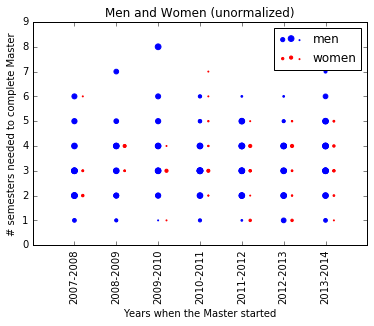

In [32]:
plt.figure()
plt.scatter(men.YearStarted, men.length, s=sizes_men, color='b', label='men')
plt.scatter(women.YearStarted+0.2, women.length, s=sizes_women, color='r', label='women')
plt.xlabel('Years when the Master started')
plt.ylabel('# semesters needed to complete Master')
plt.xticks(val, years, rotation='vertical')
plt.legend()
plt.title('Men and Women (unormalized)')
plt.show() 

Since there is a lot more male students than female, we normalize the data by the number of male/female students.

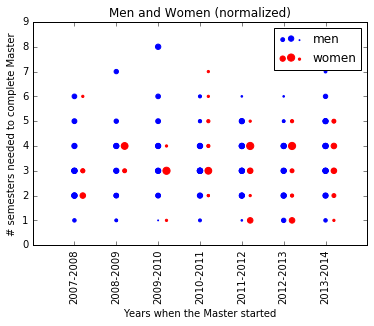

In [33]:
size = 400 # Just to get a good size on the plot
sizes_men_normalized = size*np.array(sizes_men/men.count()['length'])
sizes_women_normalized = size*np.array(sizes_women/women.count()['length'])

plt.figure()
plt.scatter(men.YearStarted, men.length, s=sizes_men_normalized, color='b', label='men')
plt.scatter(women.YearStarted+0.2, women.length, s=sizes_women_normalized, color='r', label='women')
plt.xlabel('Years when the Master started')
plt.ylabel('# semesters needed to complete Master')
plt.xticks(val, years, rotation='vertical')
plt.legend()
plt.title('Men and Women (normalized)')
plt.show() 

This graph is quite beautiful. But at the end, not that useful. Therefore, we can just say that Men and Women usually finish their Master in the same amount of time.

## Alternative way to analyse the data

In this part we show (briefly!) how we can analyze the data in a "defensive programming" way which is to only consider the ones that have a Project Master registered in ISA. 

By the way, defensive prog on data is not a good idea in general. Whathever ...


In [34]:
ma = info.loc[info['Semester'].apply(locator_ma)]

One of the main problem of the data set is that it begins on 2007-2008, when ISA system was set up. Then, students of the year before is "half registered".
Then, we will not only filter students that finished their Project Master, but also the ones that is not between these years.

In [35]:
# exemple of one of these student "half-registered"
ma.loc[ma['No Sciper'] == 128911]

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Subject,Period,Semester
473,Monsieur,Gulati Asheesh,NaN,NaN,Internet computing,NaN,NaN,Présent,NaN,NaN,128911,Informatique,2007-2008,Master semestre 2
549,Monsieur,Gulati Asheesh,NaN,NaN,Internet computing,NaN,NaN,Présent,NaN,NaN,128911,Informatique,2007-2008,Master semestre 3


In [36]:
ma_sciper = ma['No Sciper'].unique()
print(ma_sciper.size)

ma_project = ma.loc[(ma['Semester'].str.contains('Projet')) & (ma['Period'] != '2007-2008') & (ma['No Sciper'] != 159852)]
ma_project_sciper = ma_project['No Sciper'].unique()
print(ma_project_sciper.size)

976
114


There are only 115 students registered for Master Project on ISA !!

In [37]:
ma_project_career = ma.loc[ma['No Sciper'].isin(ma_project_sciper)]
ma_project_grouped = ma_project_career.groupby('No Sciper').size()
ma_project_grouped.describe()

count    114.000000
mean       4.245614
std        1.052274
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        8.000000
dtype: float64

We directly see that our data are cleaner than before, with 
* min # of semester: 3
* max # of semester: 8

That follows the academic constraints 

Let's split the data between students having a specialitation and not.

In [38]:
ma_project_career.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Subject,Period,Semester
658,Monsieur,Tran Bao Duy,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,210215,Informatique,2011-2012,Master semestre 1
659,Monsieur,Tran Le Hung,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,206923,Informatique,2011-2012,Master semestre 1
694,Monsieur,Coca Olmos Cievoloth Gilber,NaN,NaN,Service science,NaN,NaN,Présent,NaN,NaN,202059,Informatique,2011-2012,Master semestre 2
775,Monsieur,Tran Bao Duy,NaN,NaN,Internet computing,NaN,NaN,Présent,NaN,NaN,210215,Informatique,2011-2012,Master semestre 2
776,Monsieur,Tran Le Hung,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,206923,Informatique,2011-2012,Master semestre 2


In [39]:
# find all sciper of student subscribing for a minor or specialitation (can be at the first semester or later)
df_with_spec_minor = ma_project_career.loc[(ma_project_career['Spécialisation'].notnull() | ma_project_career['Filière opt.'].notnull())]
sciper_with_spec_minor = df_with_spec_minor['No Sciper'].unique()

# deduce the ones without specialitation or minor (can finish in three semesters)
sciper_without_spec_minor = set(ma_project_sciper) - set(sciper_with_spec_minor)

# set the data frames for both
df_without_spec_minor = ma_project_career.loc[ma_project_career['No Sciper'].isin(sciper_without_spec_minor)]
df_with_spec_minor = ma_project_career.loc[ma_project_career['No Sciper'].isin(sciper_with_spec_minor)]

In [40]:
df_without_spec_minor.groupby('No Sciper').size().describe()

count    86.000000
mean      4.000000
std       0.982194
min       3.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       8.000000
dtype: float64

In [41]:
df_with_spec_minor.groupby('No Sciper').size().describe()

count    28.000000
mean      5.000000
std       0.902671
min       4.000000
25%       4.000000
50%       5.000000
75%       5.000000
max       7.000000
dtype: float64

## Conclusion of method 2

Here we can see that, as expected:
* Students without spec. or minor can do their career between 3 and 6 semesters (the one with 8 semesters have probably took a "Congé" during his studies. They do their master in an average of 4 semesters.

* Students with spec. or minor can do their career between 4 and 8 semesters. They do their master in an average of 5 semesters.

In [42]:
# pro
ma.loc[ma['No Sciper'] == 166491]

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Subject,Period,Semester
430,Monsieur,Imperatori Alexandre,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,166491,Informatique,2008-2009,Master semestre 1
492,Monsieur,Imperatori Alexandre,NaN,NaN,NaN,NaN,NaN,Congé,NaN,NaN,166491,Informatique,2008-2009,Master semestre 2
404,Monsieur,Imperatori Alexandre,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,166491,Informatique,2007-2008,Master semestre 1
479,Monsieur,Imperatori Alexandre,NaN,NaN,NaN,NaN,NaN,Congé,NaN,NaN,166491,Informatique,2007-2008,Master semestre 2
740,Monsieur,Imperatori Alexandre,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,166491,Informatique,2010-2011,Master semestre 3
771,Monsieur,Imperatori Alexandre,NaN,NaN,NaN,NaN,NaN,Congé,NaN,NaN,166491,Informatique,2010-2011,Projet Master printemps
491,Monsieur,Imperatori Alexandre,NaN,NaN,NaN,NaN,NaN,Congé,NaN,NaN,166491,Informatique,2009-2010,Master semestre 1
551,Monsieur,Imperatori Alexandre,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,166491,Informatique,2009-2010,Master semestre 2
